In [1]:
pip install numpy pandas matplotlib seaborn tensorflow keras scikit-learn opencv-python albumentations


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Install these packages if not already installed using:
# pip install numpy pandas matplotlib seaborn tensorflow keras scikit-learn opencv-python albumentations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import albumentations as A
import os
import cv2
import numpy as np


In [3]:
# Load the CSV files
metadata = pd.read_csv('/Users/jishnunarasimhamoorthy/Desktop/Fall 2024/ML in Healthcare/Group Project/chest-x-ray-dataset-with-lung-segmentation-1.0.0/CXLSeg-metadata.csv')
mask = pd.read_csv('/Users/jishnunarasimhamoorthy/Desktop/Fall 2024/ML in Healthcare/Group Project/chest-x-ray-dataset-with-lung-segmentation-1.0.0/CXLSeg-mask.csv')
segmented = pd.read_csv('/Users/jishnunarasimhamoorthy/Desktop/Fall 2024/ML in Healthcare/Group Project/chest-x-ray-dataset-with-lung-segmentation-1.0.0/CXLSeg-segmented.csv')
split = pd.read_csv('/Users/jishnunarasimhamoorthy/Desktop/Fall 2024/ML in Healthcare/Group Project/chest-x-ray-dataset-with-lung-segmentation-1.0.0/CXLSeg-split.csv')

# Check the first few rows of each CSV
print(metadata.head())
print(mask.head())
print(segmented.head())
print(split.head())

                                       dicom_id  subject_id  study_id  \
0  02aa804e-bde0afdd-112c0b34-7bc16630-4e384014    10000032  50414267   
1  2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab    10000032  53189527   
2  68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714    10000032  53911762   
3  fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818    10000032  53911762   
4  ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c    10000032  56699142   

                                 Reports ViewPosition  \
0      No acute cardiopulmonary process.           PA   
1  No acute cardiopulmonary abnormality.           PA   
2        No acute intrathoracic process.           AP   
3        No acute intrathoracic process.           AP   
4      No acute cardiopulmonary process.           AP   

  PerformedProcedureStepDescription  Rows  Columns  StudyDate   StudyTime  \
0                CHEST (PA AND LAT)  3056     2544   21800506  213014.531   
1                CHEST (PA AND LAT)  3056     2544   21800626  1

EDA for CXLSeg-metadata.csv
This file contains metadata about the images, including details like patient ID, study date, and image size.

In [4]:
print(metadata.columns)

Index(['dicom_id', 'subject_id', 'study_id', 'Reports', 'ViewPosition',
       'PerformedProcedureStepDescription', 'Rows', 'Columns', 'StudyDate',
       'StudyTime', 'ProcedureCodeSequence_CodeMeaning',
       'ViewCodeSequence_CodeMeaning',
       'PatientOrientationCodeSequence_CodeMeaning'],
      dtype='object')


         subject_id      study_id           Rows        Columns     StudyDate  \
count  2.433240e+05  2.433240e+05  243324.000000  243324.000000  2.433240e+05   
mean   1.500530e+07  5.500339e+07    2716.457279    2606.443396  2.156869e+07   
std    2.881387e+06  2.887517e+06     377.438049     372.209916  2.399063e+05   
min    1.000003e+07  5.000001e+07     697.000000     776.000000  2.110011e+07   
25%    1.249116e+07  5.249891e+07    2539.000000    2539.000000  2.137071e+07   
50%    1.501437e+07  5.501022e+07    2784.000000    2544.000000  2.157050e+07   
75%    1.749032e+07  5.750623e+07    3056.000000    3050.000000  2.177033e+07   
max    1.999999e+07  5.999992e+07    3056.000000    3056.000000  2.208121e+07   

           StudyTime  
count  243324.000000  
mean   125217.900473  
std     59574.419976  
min         0.187000  
25%     82733.777000  
50%    125817.101000  
75%    171032.835750  
max    235959.437000  


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


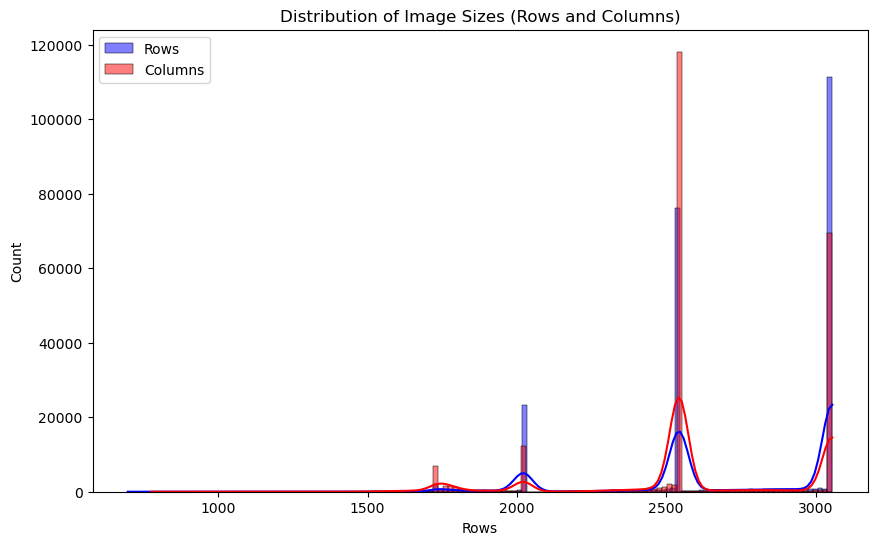

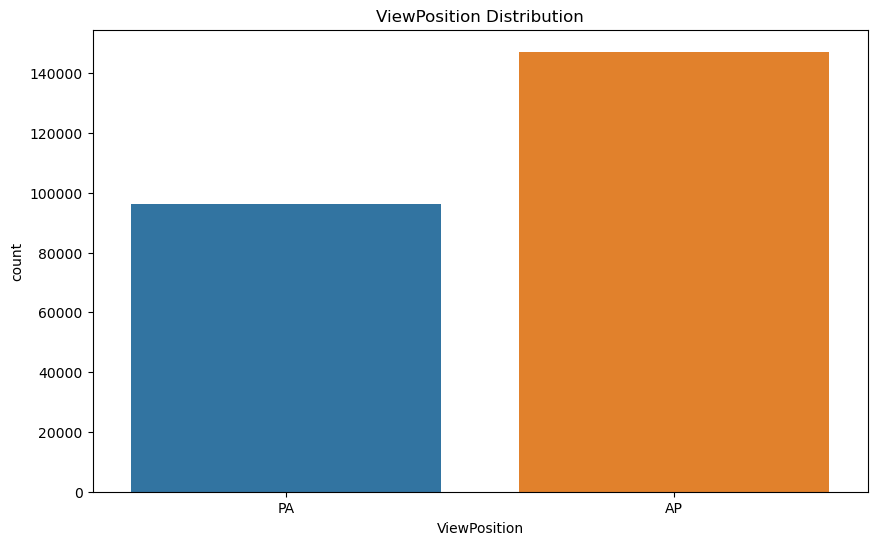

In [5]:
# Basic statistics for numerical columns
print(metadata.describe())

# Distribution of image rows and columns (image sizes)
plt.figure(figsize=(10, 6))
sns.histplot(metadata['Rows'], kde=True, color='blue', label='Rows')
sns.histplot(metadata['Columns'], kde=True, color='red', label='Columns')
plt.title('Distribution of Image Sizes (Rows and Columns)')
plt.legend()
plt.show()

# ViewPosition distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=metadata, x='ViewPosition')
plt.title('ViewPosition Distribution')
plt.show()


EDA for CXLSeg-mask.csv
This file contains paths to the masks for each image. It helps in training segmentation models.

EDA for CXLSeg-segmented.csv
This CSV file contains the segmented image paths and labels generated by the Chexpert Labeler.

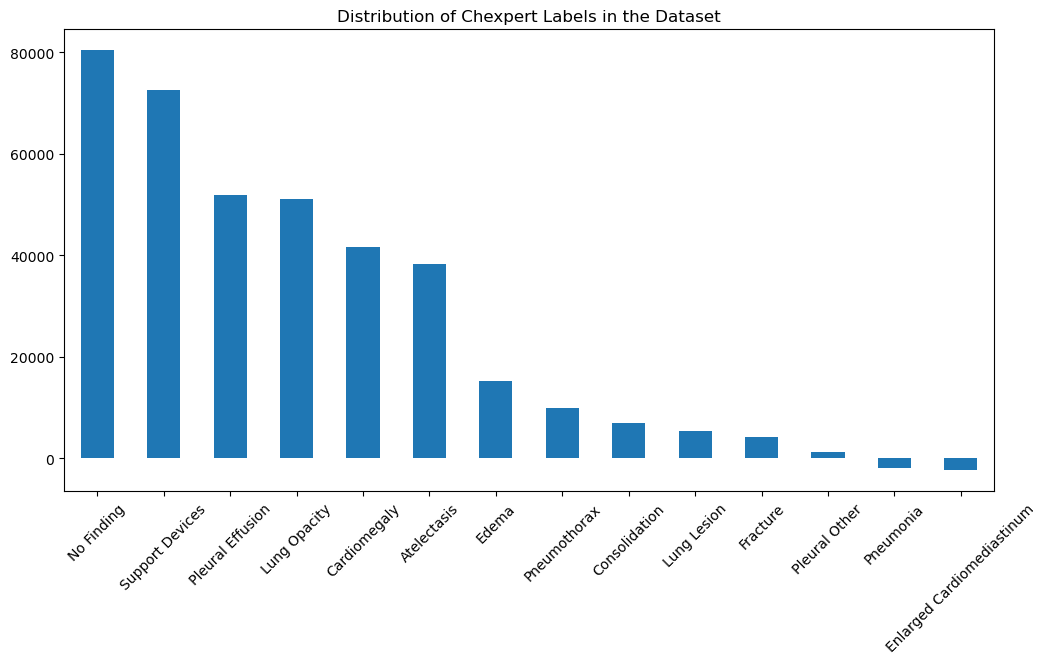

In [6]:
# Check the class distribution from Chexpert labels
chexpert_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 
                   'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 
                   'Lung Opacity', 'Pleural Effusion', 'Pneumonia', 'Pneumothorax',
                   'Pleural Other', 'Support Devices', 'No Finding']

# Plotting label counts for the Chexpert labels
plt.figure(figsize=(12, 6))
segmented[chexpert_labels].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Distribution of Chexpert Labels in the Dataset')
plt.xticks(rotation=45)
plt.show()

EDA for CXLSeg-split.csv

This CSV file contains the split information (training, validation, and testing).

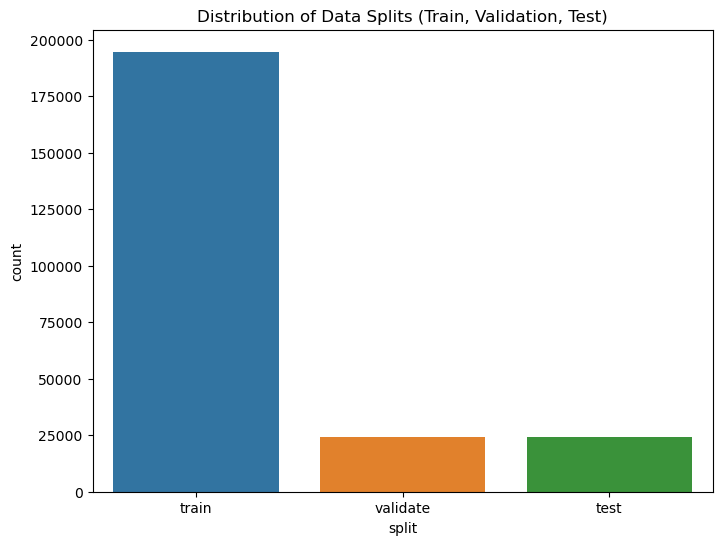

In [7]:
# Check the distribution of splits (train, test, validation)
plt.figure(figsize=(8, 6))
sns.countplot(data=split, x='split')
plt.title('Distribution of Data Splits (Train, Validation, Test)')
plt.show()

Loading Images

In [10]:
import os
import cv2
import numpy as np
import pandas as pd

# Base path where the files are stored
base_path = '/Users/jishnunarasimhamoorthy/Desktop/Fall 2024/ML in Healthcare/Group Project/chest-x-ray-dataset-with-lung-segmentation-1.0.0/files'

# Function to load an image or mask based on the dicom_id, subject_id, and study_id
def load_image(dicom_id, subject_id, study_id, is_mask=False):
    # Construct the file path
    suffix = '-mask.jpg' if is_mask else '.jpg'
    img_path = os.path.join(base_path, f"p{str(subject_id)[:2]}", f"p{subject_id}", f"s{study_id}", f"{dicom_id}{suffix}")

    # # Check if the file exists
    # if not os.path.exists(img_path):
    #     print(f"File not found: {img_path}")
    #     return None

    # # Load the image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # # Check if the image was successfully loaded
    # if img is None:
    #     print(f"Error loading image: {img_path}")
    #     return None

    # Resize the image to 224x224 for model input
    img = cv2.resize(img, (224, 224))
    return img

# Function to load the images and masks for training, validation, and testing
def load_data(df, is_mask=False):
    images = []
    for _, row in df.iterrows():
        dicom_id = row['dicom_id']
        subject_id = row['subject_id']
        study_id = row['study_id']
        img = load_image(dicom_id, subject_id, study_id, is_mask)
        if img is not None:
            images.append(img)
    return np.array(images)

# Example: Load your CSV file with metadata (replace with actual file path)
df = pd.read_csv('/Users/jishnunarasimhamoorthy/Desktop/Fall 2024/ML in Healthcare/Group Project/chest-x-ray-dataset-with-lung-segmentation-1.0.0/CXLSeg-split.csv')  # Example: split CSV file

# Load images and masks
images = load_data(df, is_mask=False)  # This will load the images
masks = load_data(df, is_mask=True)    # This will load the corresponding masks

# Display the shape of the resulting arrays
print(f"Number of images: {images.shape}")
print(f"Number of masks: {masks.shape}")


KeyboardInterrupt: 